In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import utils_x
import xgboost as xgb
from scipy.stats import norm
from utils_x import pos_neg_corr
from utils_x import factor_yhat_corr
from utils_x import train_op
from utils_x import InverseNormalCDF
from utils_x import plot_conditional_expectation
from utils_x import combine_plus
from utils_x import combine_mult
from utils_x import single_train
from utils_x import get_forecast
sns.set(style="darkgrid")
import logging
import time
import itertools
import imp

In [2]:
all_col = ['unique_symbol', 'date_time', 'close', 'turnover', 'open', 'high', 'low', 'volume',\
           "use_tag300", "use_tag500", "use_tag50", "adjustment", "adjustment_cumsum"]

In [3]:
%%time
print("---------------------------------------------------- load and merge -------------------------------------------------------------")
data = pd.read_csv('index500_v2_adjustment.csv', index_col=0)
data["date_time"]  = pd.to_datetime(data["date_time"])
data = data[all_col].copy()
data['wap'] = data['turnover']/data['volume']
data["adjustment"] =  data["adjustment"].fillna(0)


begin_interval_df = pd.read_csv('930_interval.csv', index_col=0)
begin_interval_df["date_time"] = pd.to_datetime(begin_interval_df["date_time"])
index_df = pd.read_csv('index500_open.csv', index_col=0)
index_df["date_time"]  = pd.to_datetime(index_df["date_time"])
future_df = pd.read_csv('future500_open.csv', index_col=0)
future_df["date_time"]  = pd.to_datetime(future_df["date_time"])
market_cap = pd.read_csv('market_cap.csv', index_col=0)
market_cap["date_time"]  = pd.to_datetime(market_cap["date_time"])

data = pd.merge(data, begin_interval_df, how="left", on=['unique_symbol','date_time'])
data = pd.merge(data, market_cap, how="left", on=['unique_symbol','date_time'])
data = pd.merge(data, index_df, how="left", on=['date_time'])
data = pd.merge(data, future_df, how="left", on=['date_time'])


print("------------------------------------------------------ return factor-----------------------------------------------------------------")
gb_unique_symbol = data.groupby(["unique_symbol"])
data["close_y1"] = gb_unique_symbol["close"].transform(lambda x: x.shift(1))
data["open_y1"] = gb_unique_symbol["open"].transform(lambda x: x.shift(1))
data["high_y1"] = gb_unique_symbol["high"].transform(lambda x: x.shift(1))
data["low_y1"] = gb_unique_symbol["low"].transform(lambda x: x.shift(1))
data["wap_y1"] = gb_unique_symbol["wap"].transform(lambda x: x.shift(1))
data["volume_y1"] = gb_unique_symbol["volume"].transform(lambda x: x.shift(1))
data["turnover_y1"] = gb_unique_symbol["turnover"].transform(lambda x: x.shift(1))

data["r_raw"] = (data["close"] -  data["adjustment"])/ data["close_y1"] - 1
data["r_open"] = (data["close"] -  data["adjustment"])/ data["open_y1"] - 1
data["r_high"] = (data["close"] -  data["adjustment"])/ data["high_y1"] - 1
data["r_low"] = (data["close"] -  data["adjustment"])/ data["low_y1"] - 1
data["r_wap"] = (data["close"] -  data["adjustment"])/ data["wap_y1"] - 1
data["r_volume"] = data["volume"] / data["volume_y1"] 
data["r_turnover"] = data["turnover"] / data["turnover_y1"] 

data["abs_r_raw"] = np.abs(data["r_raw"])
data["square_r_raw"] = data["r_raw"] * data["r_raw"]
data["r"] = data["r_raw"] - data["r_IC"]
data["abs_r"] = np.abs(data["r"])
data["square_r"] = data["r_raw"] * data["r_raw"]

print("----------------------------------------------------------- Y --------------------------------------------------------------------")
data["t+1_type"] = gb_unique_symbol["type"].transform(lambda x: x.shift(-1))
data["t+1_open"] = gb_unique_symbol["open"].transform(lambda x: x.shift(-1))
data["t+2_open"] = gb_unique_symbol["open"].transform(lambda x: x.shift(-2))
data['t+2_adjustment'] = gb_unique_symbol["adjustment"].transform(lambda x: x.shift(-2))
data['t+1_adjustment_cumsum'] = gb_unique_symbol['adjustment_cumsum'].transform(lambda x: x.shift(-1))

data["y_open"] = data["t+2_open"] - data['t+2_adjustment']
data['return'] = data['y_open'] / data['t+1_open'] - 1

print("---------------------------------------------------- overnight factor------------------------------------------------------------")
data["r1"]  = (data["t+1_930close_mid"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["open"] -1
data["limit_tag"] = data["t+1_open"]/data["close"]
# print("-------------------  EMA r --------------------")
# ema_r_nums = list(range(1,11)) + [0.5, 0.75, 1.25, 1.5, 1.75, 20]
# ema_r_factor = []
# for i in ema_r_nums: 
#     data["r_ema" + str(i)] = gb_unique_symbol["r"].transform(lambda x: x.ewm(halflife = i).mean())
#     ema_r_factor.append("r_ema" + str(i))

print("--------------------------------------------------------- MA rr------------------------------------------------------------------")
ma_rr_nums = list(range(1,6)) 
ma_rr_factor = []
for i in ma_rr_nums: 
    data["rr_high_ma" + str(i)] = gb_unique_symbol["r_high"].transform(lambda x: x.rolling(i).mean())
    data["rr_low_ma" + str(i)] = gb_unique_symbol["r_low"].transform(lambda x: x.rolling(i).mean())
    data["rr_wap_ma" + str(i)] = gb_unique_symbol["r_wap"].transform(lambda x: x.rolling(i).mean())
    data["rr_open_ma" + str(i)] = gb_unique_symbol["r_open"].transform(lambda x: x.rolling(i).mean())
    ma_rr_factor.append("rr_high_ma" + str(i))
    ma_rr_factor.append("rr_low_ma" + str(i))
    ma_rr_factor.append("rr_wap_ma" + str(i))
    ma_rr_factor.append("rr_open_ma" + str(i))

print("-------------------------------------------------------- MA r_IC------------------------------------------------------------------")
ma_r_ic_nums = list(range(1,11)) 
ma_r_ic_factor = []
for i in ma_r_ic_nums: 
    data["r_IC_ma" + str(i)] = gb_unique_symbol["r_IC"].transform(lambda x: x.rolling(i).mean())
    ma_r_ic_factor.append("r_IC_ma" + str(i))

    
for i in range(1,6): 
    data["abs_r_IC_ma" + str(i)] = gb_unique_symbol["r_IC"].transform(lambda x: np.abs(x).rolling(i).mean())
    
print("------------------------------------------------------- MA volume ---------------------------------------------------------------")
ma_volume_nums = list(range(1,6)) 
ma_volume_factor = []
data["volume_ma10"] = gb_unique_symbol["r_volume"].transform(lambda x: x.rolling(10).mean())
data["turnover_ma10"] = gb_unique_symbol["r_turnover"].transform(lambda x: x.rolling(10).mean())
for i in ma_volume_nums: 
    data["volume_ma" + str(i)] = gb_unique_symbol["r_volume"].transform(lambda x: x.rolling(i).mean())
    data["volume_s_ma" + str(i)] = data["volume_ma" + str(i)] / (data["volume_ma" + str(i)] + data["volume_ma10"])
    ma_volume_factor.append("volume_s_ma" + str(i))
    data["turnover_ma" + str(i)] = gb_unique_symbol["r_turnover"].transform(lambda x: x.rolling(i).mean())
    data["turnover_s_ma" + str(i)] = data["turnover_ma" + str(i)] / (data["turnover_ma" + str(i)] + data["turnover_ma10"])
    ma_volume_factor.append("turnover_s_ma" + str(i))

print("-------------------------------------------------------- MA r1-----------------------------------------------------------------")
ma_r1_nums = list(range(1,4)) 
ma_r1_factor = []
for i in ma_r1_nums: 
    data["r1_ma" + str(i)] = gb_unique_symbol["r1"].transform(lambda x: x.rolling(i).mean())
    ma_r1_factor.append("r1_ma" + str(i))
print("------------------------------------------------------ MA abs_r_raw--------------------------------------------------------------")
ma_abs_r_raw_nums = list(range(1,16)) + [20, 30]
ma_abs_r_raw_factor = []
for i in ma_abs_r_raw_nums: 
    data["abs_r_raw_ma" + str(i)] = gb_unique_symbol["abs_r_raw"].transform(lambda x: x.rolling(i).mean())
    ma_abs_r_raw_factor.append("abs_r_raw_ma" + str(i))
print("-------------------------------------------------------- MA r_raw----------------------------------------------------------------")
ma_r_raw_nums = list(range(1,16)) + [20, 30]
ma_r_raw_factor = []
for i in ma_r_raw_nums: 
    data["r_raw_ma" + str(i)] = gb_unique_symbol["r_raw"].transform(lambda x: x.rolling(i).mean())
    ma_r_raw_factor.append("r_raw_ma" + str(i))
    
print("---------------------------------------------------------- MA r------------------------------------------------------------------")
ma_r_nums = list(range(1,16)) + [20, 30]
ma_r_factor = []
for i in ma_r_nums: 
    data["r_ma" + str(i)] = gb_unique_symbol["r"].transform(lambda x: x.rolling(i).mean())
    ma_r_factor.append("r_ma" + str(i))

print("------------------------------------------------------- MA turnover------------------------------------------------------------------")
data["Turnover"] = data["turnover"]/data["capital"]
for i in list(range(1,6))+[10]: 
    data["Turnover_ma" + str(i)] = gb_unique_symbol["Turnover"].transform(lambda x: x.rolling(i).mean())    
    
# print("------------------- EMA abs_r_raw---------------------")
# ema_abs_r_raw_nums = list(range(1,11)) + [0.5, 0.75, 1.25, 1.5, 1.75, 2.5]
# ema_abs_r_raw_factor = []
# for i in ema_abs_r_raw_nums: 
#     data["abs_r_raw_ema" + str(i)] = gb_unique_symbol["abs_r_raw"].transform(lambda x: x.ewm(halflife = i).mean())
#     ema_abs_r_raw_factor.append("abs_r_raw_ema" + str(i))

# print("------------------- MA square_r_raw---------------------")
# ma_square_r_raw_nums = list(range(1,16)) + [20, 30]
# ma_square_r_raw_factor = []
# for i in ma_square_r_raw_nums: 
#     data["square_r_raw_ma" + str(i)] = gb_unique_symbol["square_r_raw"].transform(lambda x: x.rolling(i).mean())
#     ma_square_r_raw_factor.append("square_r_raw_ma" + str(i))

# print("------------------- MA abs_r---------------------")
# ma_abs_r_nums = list(range(1,16)) + [20, 30]
# ma_abs_r_factor = []
# for i in ma_abs_r_nums: 
#     data["abs_r_ma" + str(i)] = gb_unique_symbol["abs_r"].transform(lambda x: x.rolling(i).mean())
#     ma_abs_r_factor.append("abs_r_ma" + str(i))


---------------------------------------------------- load and merge -------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


------------------------------------------------------ return factor-----------------------------------------------------------------
----------------------------------------------------------- Y --------------------------------------------------------------------
---------------------------------------------------- overnight factor------------------------------------------------------------
--------------------------------------------------------- MA rr------------------------------------------------------------------
-------------------------------------------------------- MA r_IC------------------------------------------------------------------
------------------------------------------------------- MA volume ---------------------------------------------------------------
-------------------------------------------------------- MA r1-----------------------------------------------------------------
------------------------------------------------------ MA abs_r_raw-------------------

In [4]:
data[["capital", "unique_symbol", "date_time", "turnover", "volume", "Turnover_ma1"]]

,capital,unique_symbol,date_time,turnover,volume,Turnover_ma1
0,1.555059e+11,600000,2010-01-29,1.062334e+09,53690100,0.006831
1,1.075193e+10,600017,2010-01-29,1.296641e+08,18318200,0.012060
2,5.306429e+10,600005,2010-01-29,2.600372e+08,38191600,0.004900
3,1.164000e+10,600006,2010-01-29,6.664664e+07,11386300,0.005726
4,1.096931e+10,600007,2010-01-29,4.127214e+07,3772600,0.003763
...,...,...,...,...,...,...
5807463,1.936880e+09,300652,2019-06-28,2.157614e+07,976235,0.011140
5807464,4.668800e+09,300653,2019-06-28,5.287180e+07,906766,0.011324
5807465,1.799321e+09,300654,2019-06-28,3.941205e+07,3040300,0.021904
5807466,1.583194e+10,300630,2019-06-28,1.345949e+08,2339874,0.008501


In [5]:
print("-------------------------------------------------------- set Universe---------------------------------------------------------------")
data = data[data["use_tag500"] == 1].copy()
data = data[data["t+1_type"]==0].copy()
print("----------------------------------------------------------- label ------------------------------------------------------------------")
gb_date_time = data.groupby(['date_time'])
data['return_std'] = gb_date_time["return"].transform(lambda x: x.std())
data["return_mean"] = gb_date_time["return"].transform(lambda x: x.mean())
data["return_deindex"] = data["return"] - data["index500_return"]
data['label'] = data["return_deindex"]/data['return_std']
data['mr'] = gb_date_time["return"].transform(lambda x: x.mean())

data["cont"] = gb_date_time["unique_symbol"].transform(lambda x: x.count())
data["cont"] = data["cont"] + 1
data["r_raw_uniform"] = gb_date_time["r_raw"].transform(lambda x: x.rank())
data["r_raw_uniform"] = data["r_raw_uniform"] / data["cont"]
print(data["label"].mean()) 
data = data[~data['label'].isnull()].copy()
print(data["label"].mean())

print("--------------------------------------------------------- add factor ---------------------------------------------------------------")
gb_unique_symbol =  data.groupby(['unique_symbol'])
gb_date_time =  data.groupby(['date_time'])
ma_uniform_nums = list(range(1,6))
ma_uniform_factor = []
for i in ma_uniform_nums: 
    data["uniform_ma" + str(i)] = gb_unique_symbol["r_raw_uniform"].transform(lambda x: x.rolling(i).mean())
    ma_uniform_factor.append("uniform_ma" + str(i))
        
data["r1_distribute"] = gb_date_time["r1"].transform(lambda x: (x-x.mean())/x.std())

data["turnover_rank"] = gb_date_time['turnover'].transform( lambda x:x.rank())
data["turnover_norm"] = data["turnover_rank"] / data["cont"]
data["turnover_norm"] = data["turnover_norm"].apply(lambda x: InverseNormalCDF(x))

data["volume_rank"] = gb_date_time['volume'].transform( lambda x:x.rank())
data["volume_norm"] = data["volume_rank"] / data["cont"]
data["volume_norm"] = data["volume_norm"].apply(lambda x: InverseNormalCDF(x))

data["close_rank"] = gb_date_time['close'].transform( lambda x:x.rank())
data["close_norm"] = data["close_rank"] / data["cont"]
data["close_norm"] = data["close_norm"].apply(lambda x: InverseNormalCDF(x))

data["r"] = data["close"]/ data["open"] - 1
data["r_distribute"] = gb_date_time["r"].transform(lambda x: (x-x.mean())/x.std())
data["amplitude_ratio"] =  abs((data["close"] - data["open"])/(data["high"] - data["low"]))
data["amplitude_ratio"] = data["amplitude_ratio"].fillna(0)
data["amplitude"] = (data["high"] - data["low"]) / data["close"]

data["std"] = gb_date_time["return_std"].transform(lambda x: x.shift(1))
data["std_ma2"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(2).mean())
data["std_ma3"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(3).mean())
data["std_ma4"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(4).mean())
data["std_ma5"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(5).mean())
data["std_ma6"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(6).mean())
data["std_ma7"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(7).mean())
data["std_ma8"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(8).mean())
data["std_ma10"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(10).mean())
data["std_ma15"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(15).mean())

-------------------------------------------------------- set Universe---------------------------------------------------------------
----------------------------------------------------------- label ------------------------------------------------------------------
0.005549952793376403
0.005549952793376407
--------------------------------------------------------- add factor ---------------------------------------------------------------


In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
data.groupby(["date_time"])["r1"].std().rolling(130).mean().plot(label =1)
data.groupby(["date_time"])["r1"].mean().rolling(130).std().plot(label =4)
plt.legend()

In [ ]:
data.groupby(["date_time"])["return_mean"].mean().cumsum().plot(label =1)
data.groupby(["date_time"])["index500_return"].mean().cumsum().plot(label =2)
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
data.groupby(["date_time"])["Turnover_ma1"].std().rolling(1).mean().plot(label =1)
data.groupby(["date_time"])["Turnover_ma1"].std().rolling(10).mean().plot(label =2)
data.groupby(["date_time"])["Turnover_ma1"].std().ewm(halflife =30).mean().plot(label =3)
data.groupby(["date_time"])["Turnover_ma1"].mean().rolling(30).mean().plot(label =4)
plt.legend()

In [ ]:
# base = [["r_raw_ma1", "r_raw_ma2", "r_raw_ma3", "r_raw_ma4", "r_raw_ma5", "r_raw_ma7", "r_raw_ma20",
#         "r_ma1","r_ma2","r_ma3","r_ma6","r_ma9",'abs_r_raw_ma1','abs_r_raw_ma3','abs_r_raw_ma4','abs_r_raw_ma5']]
# add1 = list(itertools.combinations(ma_abs_r_raw_factor, 1))
# add1 = [list(i) for i in add1]
# factor_group_l = combine_mult(base, add1)
# print(len(factor_group_l))
# factor_group_l

In [6]:
use_f = []
use_f1 = ["r_raw_ma1", "r_raw_ma2", "r_raw_ma3", "r_raw_ma4", "r_raw_ma5","r_raw_ma7", "r_raw_ma20"]
use_f2 = ["r_ma1", "r_ma2","r_ma3", "r_ma6", "r_ma9",]
use_f3 = ["abs_r_raw_ma1", "abs_r_raw_ma3", "abs_r_raw_ma4", "abs_r_raw_ma5", "abs_r_raw_ma10"]
use_f4 = ["r1", "r1_ma2", "r1_distribute"]
use_f5 = ["r_IC_ma1", "r_IC_ma5", "r_IC_ma7"] + ma_rr_factor
use_f6 = ["close_norm", "volume_norm", "turnover_norm"]
use_f7 = ma_volume_factor
use_f8 = ["r", "r_distribute", "amplitude", "amplitude_ratio"]
use_f9 = ["Turnover_ma1", "Turnover_ma2", "Turnover_ma3", "Turnover_ma4", "Turnover_ma5", "Turnover_ma10"]
use_f = use_f + use_f1 + use_f2 + use_f3 + use_f4 + use_f5 + use_f6 + use_f7 + use_f8 + use_f9
# use_f = use_f + ["abs_r_IC_ma1","abs_r_IC_ma2","abs_r_IC_ma3","abs_r_IC_ma4","abs_r_IC_ma5"]
use_f = use_f + ["std", "std_ma2", "std_ma3", "std_ma4", "std_ma5"]

In [ ]:
# gb = data.groupby(["date_time"])
# need_deVolatility = use_f8  
# for f in need_deVolatility:
#     print(f)
#     data["temp_std"] = gb[f].transform(lambda x : x.std())
#     data["temp_std"] = gb["temp_std"].transform(lambda x: x.ewm(halflife = 5).mean()) 
#     data[f] = data[f]/data["temp_std"]

In [7]:
# 批量训练
print(len(use_f))
imp.reload(logging)
t1 = datetime.datetime(2010,1,1)
t2 = datetime.datetime(2014,6,1)
t3 = datetime.datetime(2015,6,1)
t4 = datetime.datetime(2019,7,1)

params = {
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'alpha': 100,
            "nthread": 20,
            "num_parallel_tree":10,
            "tree_method": 'gpu_hist',
            "gpu_id":1,
#             "max_bin":64
#             "min_child_weight": 1000
        }
print(params)
early = 30
num_rounds = 200
split_type = "random"
imp.reload(utils_x)
bst  = utils_x.single_train(data, use_f, t1, t2, t3, t4, params, early, num_rounds, split_type)

{'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 100, 'nthread': 20, 'num_parallel_tree': 10, 'tree_method': 'gpu_hist', 'gpu_id': 1}
factor:r_raw_ma1|r_raw_ma2|r_raw_ma3|r_raw_ma4|r_raw_ma5|r_raw_ma7|r_raw_ma20|r_ma1|r_ma2|r_ma3|r_ma6|r_ma9|abs_r_raw_ma1|abs_r_raw_ma3|abs_r_raw_ma4|abs_r_raw_ma5|abs_r_raw_ma10|r1|r1_ma2|r1_distribute|r_IC_ma1|r_IC_ma5|r_IC_ma7|rr_high_ma1|rr_low_ma1|rr_wap_ma1|rr_open_ma1|rr_high_ma2|rr_low_ma2|rr_wap_ma2|rr_open_ma2|rr_high_ma3|rr_low_ma3|rr_wap_ma3|rr_open_ma3|rr_high_ma4|rr_low_ma4|rr_wap_ma4|rr_open_ma4|rr_high_ma5|rr_low_ma5|rr_wap_ma5|rr_open_ma5|close_norm|volume_norm|turnover_norm|volume_s_ma1|turnover_s_ma1|volume_s_ma2|turnover_s_ma2|volume_s_ma3|turnover_s_ma3|volume_s_ma4|turnover_s_ma4|volume_s_ma5|turnover_s_ma5|r|r_distribute|amplitude|amplitude_ratio|Turnover_ma1|Turnover_ma2|Turnover_ma3|Turnover_ma4|Turnover_ma5|Turnover_ma10|std|std_ma2|std_ma3|std_ma4|std_ma5


71
{'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 100, 'nthread': 20, 'num_parallel_tree': 10, 'tree_method': 'gpu_hist', 'gpu_id': 1}
-------------------- train -----------------------
[0]	train-rmse:1.05728	eval-rmse:1.09505
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 30 rounds.
[1]	train-rmse:1.02652	eval-rmse:1.06547
[2]	train-rmse:1.01039	eval-rmse:1.04990
[3]	train-rmse:1.00173	eval-rmse:1.04145
[4]	train-rmse:0.99687	eval-rmse:1.03718
[5]	train-rmse:0.99412	eval-rmse:1.03478
[6]	train-rmse:0.99241	eval-rmse:1.03338
[7]	train-rmse:0.99117	eval-rmse:1.03231
[8]	train-rmse:0.99023	eval-rmse:1.03154
[9]	train-rmse:0.98953	eval-rmse:1.03091
[10]	train-rmse:0.98888	eval-rmse:1.03041
[11]	train-rmse:0.98829	eval-rmse:1.03008
[12]	train-rmse:0.98770	eval-rmse:1.02971
[13]	train-rmse:0.98718	eval-rmse:1.02932
[14]	train-rmse:0.98670	eval-rmse:1.02900
[15]	train-rmse:0.98629	eval-

[185]	train-rmse:0.95190	eval-rmse:1.01830
[186]	train-rmse:0.95175	eval-rmse:1.01828
[187]	train-rmse:0.95161	eval-rmse:1.01832
[188]	train-rmse:0.95147	eval-rmse:1.01827
[189]	train-rmse:0.95133	eval-rmse:1.01824
[190]	train-rmse:0.95120	eval-rmse:1.01824
[191]	train-rmse:0.95106	eval-rmse:1.01822
[192]	train-rmse:0.95091	eval-rmse:1.01816
[193]	train-rmse:0.95078	eval-rmse:1.01816
[194]	train-rmse:0.95064	eval-rmse:1.01816
[195]	train-rmse:0.95048	eval-rmse:1.01812
[196]	train-rmse:0.95033	eval-rmse:1.01812
[197]	train-rmse:0.95019	eval-rmse:1.01813
[198]	train-rmse:0.95005	eval-rmse:1.01811
[199]	train-rmse:0.94991	eval-rmse:1.01805



test_set2015:0.1551522079475843
test_set2016:0.16385287904513324
test_set2017:0.12381545443017368
test_set2018:0.07277758653250126
test_set2019:0.07844464096382744
test_all_corrcoef:0.11996893862129743
test_all_corrcoef_Nodemean:0.11149331070603206


val_set2014:0.13176457958976132
val_set2015:0.27544231478467834
val__all_corrcoef:0.1919761341523046
val__all_corrcoef_Nodemean:0.19854416457621551


train_set2010:0.38622867743372474
train_set2011:0.3506957678583756
train_set2012:0.3457886559396208
train_set2013:0.3499934655214542
train_set2014:0.3328160715401292
train_corrcoef:0.35610226868985545
train_corrcoef_Nodemean:0.3479561224566437

tree_nums:2000
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-p

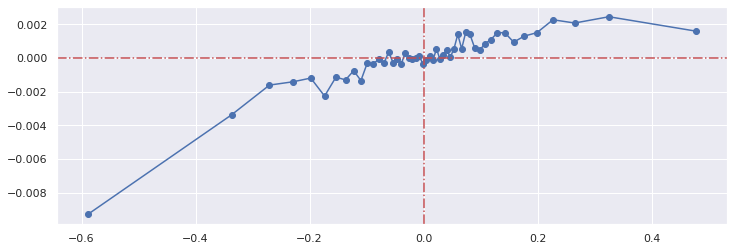

corr 0.07480983089365541
neg_corr 0.09330315259851803
pos_corr 0.0211618644547099


In [8]:
tb = datetime.datetime(2018,1,1)
te = datetime.datetime(2019,7,1)
imp.reload(utils_x)
utils_x.pos_neg_corr(data, use_f, tb, te, bst)

0.11996893862129743


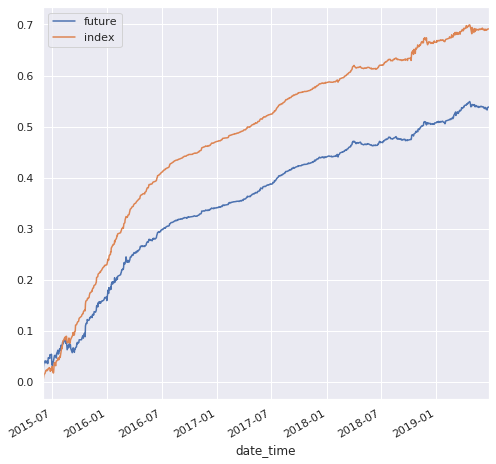

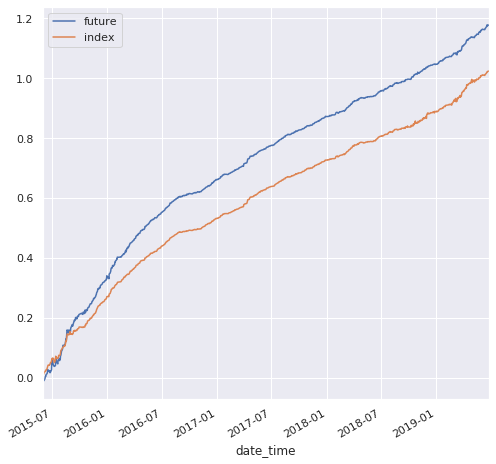

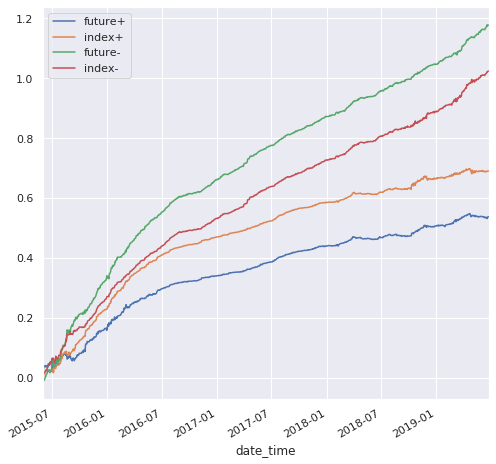

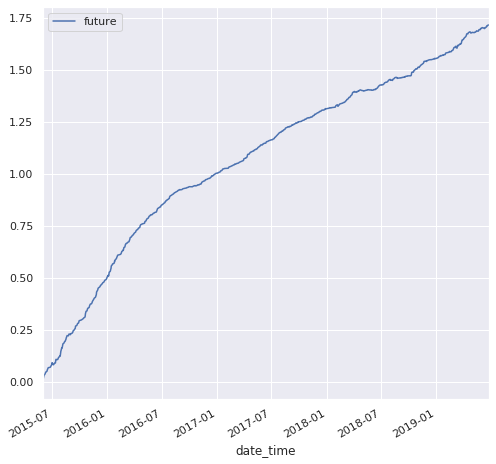

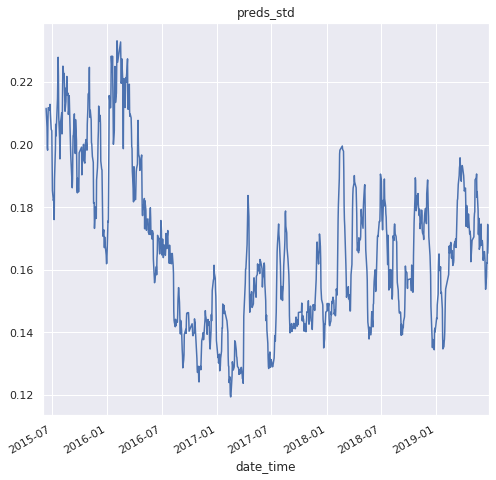

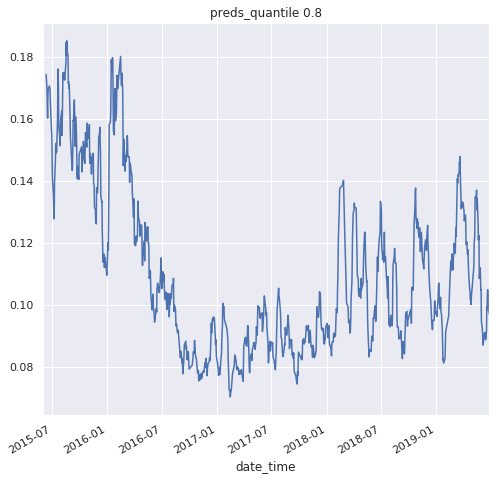

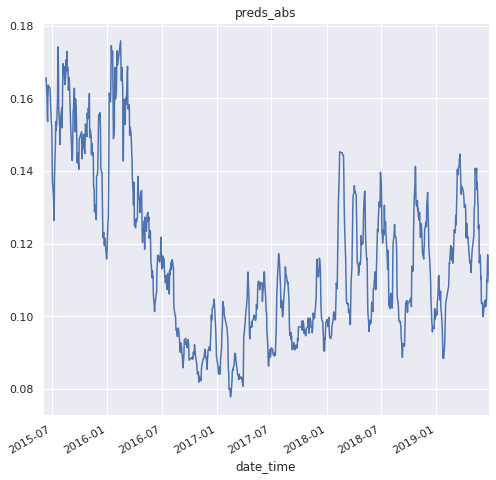

In [9]:
tb = datetime.datetime(2015,6,1)
te = datetime.datetime(2019,7,1)
imp.reload(utils_x)
data_sim = utils_x.pnl_plot(tb, te, data, use_f, bst)

In [ ]:
factor_yhat_corr(bst, data, use_f, t1, t3)

In [ ]:


# 批量训练

# print(len(use_f))
# imp.reload(logging)
# t1 = datetime.datetime(2010,1,1)
# t2 = datetime.datetime(2014,6,1)
# t3 = datetime.datetime(2015,6,1)
# t4 = datetime.datetime(2018,1,1)
# params = {
#             'max_depth': 6,
#             'subsample': 0.8,
#             'colsample_bytree': 0.8,
#             'alpha': 100,
#             "nthread": 20,
#             "num_parallel_tree":10,
#             "tree_method": 'gpu_hist',
# #             "min_child_weight": 1000
#         }

# import utils_x
# imp.reload(utils_x)
# print(params)
# bst  = utils_x.single_train(data, use_f, t1, t2, t3, t4, params)

# tb = datetime.datetime(2016,9,1)
# te = datetime.datetime(2017,4,1)
# pos_neg_corr(data, use_f, tb, te, bst)

# tb = datetime.datetime(2015,6,1)
# te = datetime.datetime(2018,1,1)
# imp.reload(utils_x)
# utils_x.pnl_plot(tb, te, data, use_f, bst)

In [ ]:
# 单次训练分析
early = 30
t1 = datetime.datetime(2010,1,1)
t2 = datetime.datetime(2014,6,1)
t3 = datetime.datetime(2015,6,1)
t4 = datetime.datetime(2018,1,1)
data_tr = data[ (data["date_time"] >= t1) & (data["date_time"] < t2)].copy()
data_te = data[ (data["date_time"] >= t2) & (data["date_time"] < t3)].copy()
data_fin = data[ (data["date_time"] >= t3) & (data["date_time"] < t4)].copy()

In [ ]:
tree_nums = bst.best_ntree_limit 
preds = bst.predict(xgb.DMatrix(data_fin[use_f]), ntree_limit=tree_nums)
data_fin["preds"] = list(preds)
preds = bst.predict(xgb.DMatrix(data_te[use_f]), ntree_limit=tree_nums)
data_te["preds"] = list(preds)
preds = bst.predict(xgb.DMatrix(data_tr[use_f]), ntree_limit=tree_nums)
data_tr["preds"] = list(preds)
gb = data_fin.groupby(['date_time'])['preds']
data_fin["pred_mean"] = gb.transform(lambda x: x.mean())
data_fin["preds_demean"] = data_fin["preds"] - data_fin["pred_mean"]
data_fin["return_demean"] = data_fin["return"] - data_fin["mr"]
gb = data_tr.groupby(['date_time'])['preds']
data_tr["pred_mean"] = gb.transform(lambda x: x.mean())
data_tr["preds_demean"] = data_tr["preds"] - data_tr["pred_mean"]
data_tr["return_demean"] = data_tr["return"] - data_tr["mr"]
gb = data_te.groupby(['date_time'])['preds']
data_te["pred_mean"] = gb.transform(lambda x: x.mean())
data_te["preds_demean"] = data_te["preds"] - data_te["pred_mean"]
data_te["return_demean"] = data_te["return"] - data_te["mr"]

In [ ]:
df_tree = bst.trees_to_dataframe()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.tick_params(labelsize=12)
f_importance_bar(importance_dic)

In [ ]:
import shap
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(data_tr[use_f])
shap.summary_plot(shap_values, data[use_f], plot_type="bar")

In [ ]:
all_tree_rounds = bst.best_ntree_limit + early
tr_step = []
te_step = []
fin_step = []
for i in range(1, all_tree_rounds):
    if i % 5==0:
        print("Tree numbers：" ,i ,"best_ntree_limit:", bst.best_ntree_limit, "early_stop:", early)
    temp1 = bst.predict( xgb.DMatrix(data_tr[use_f]),ntree_limit= i)
    temp2 = bst.predict( xgb.DMatrix(data_te[use_f]),ntree_limit= i)
    temp3 = bst.predict( xgb.DMatrix(data_fin[use_f]),ntree_limit= i)
    corrcoef1 = np.corrcoef(temp1, data_tr["return"] - data_tr["mr"])[0,1]
    corrcoef2 = np.corrcoef(temp2, data_te["return"] - data_te["mr"])[0,1]
    corrcoef3 = np.corrcoef(temp3, data_fin["return"] - data_fin["mr"])[0,1]
    tr_rmse = ((temp1 - data_tr["label"])*(temp1 - data_tr["label"])).mean()
    te_rmse = ((temp2 - data_te["label"])*(temp2 - data_te["label"])).mean()
    fin_rmse = ((temp3 - data_fin["label"])*(temp3 - data_fin["label"])).mean()
    tr_step.append([tr_rmse, corrcoef1])
    te_step.append([te_rmse, corrcoef2])
    fin_step.append([fin_rmse, corrcoef3])

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,0], label="Train")
plt.plot(np.array(te_step)[:,0], label="Val")
plt.plot(np.array(fin_step)[:,0], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("RMSE")
plt.vlines(bst.best_ntree_limit, 0.94, 1, colors = "c", linestyles = "dashed")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,1], label="Train")
plt.plot(np.array(te_step)[:,1], label="Val")
plt.plot(np.array(fin_step)[:,1], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("Corr")
plt.vlines(bst.best_ntree_limit, 0.05, 0.25, colors = "c", linestyles = "dashed")
plt.legend()

In [ ]:
all_tree_rounds = bst.best_ntree_limit + early
zero = []
leave_node = []
tree_node = []
for tree_id in range(1, all_tree_rounds):
    zero.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf") & (df_tree["Gain"] == 0)].shape[0])
    leave_node.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf")].shape[0])
    tree_node.append(df_tree[(df_tree["Tree"] == tree_id)].shape[0])

In [ ]:
zero = np.array(zero)
plt.rcParams['figure.figsize'] = (6, 6)
leave_node = np.array(leave_node)
tree_node = np.array(tree_node)
plt.vlines(bst.best_ntree_limit, 0.35, 0.65, colors = "r", linestyles = "dashed")
plt.xlabel("Tree Numbers")
plt.ylabel("z_ratio(zero_leave / leave)")
zr = np.mean(zero/leave_node)
plt.text(10, 0.65, r"z_ratio mean: %.2f" %(zr) , fontsize=15)
plt.plot(zero/leave_node)

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.text(20, 120, r"Average leave_node: %.2f" %(np.mean(leave_node)) , fontsize=15)
plt.xlabel("Tree Numbers")
plt.ylabel("Leave_Node Nums")
plt.plot(tree_node)
plt.vlines(bst.best_ntree_limit, 50, 120, colors = "r", linestyles = "dashed")

In [ ]:
tb = datetime.datetime(2015,6,1)
te = datetime.datetime(2018,1,1)
data_sim = data[ (data["date_time"] >= tb) & (data["date_time"] < te)]
sim_pred =  bst.predict(xgb.DMatrix(data_sim[use_f]), ntree_limit= bst.best_ntree_limit)
data_sim["preds"] = sim_pred

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
data_sim["preds"].hist(bins= 100)

In [ ]:
data_sim = data_sim.reset_index(drop=True)
gb = data_sim.groupby(['date_time'])['preds']
data_sim["pred_mean"] = gb.transform(lambda x: x.mean())
data_sim["preds"] = data_sim["preds"] - data_sim["pred_mean"]

In [ ]:
np.corrcoef(data_sim["preds"], data_sim["return"] - data_sim["mr"])[0,1]

In [ ]:
data_sim["preds"].hist(bins= 100)

In [ ]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

In [ ]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

In [ ]:
gb = data_sim.groupby(["unique_symbol"])
data_sim["yesterday_preds"] = gb["preds"].shift(1)
data_sim["preds"] = data_sim.apply(lambda x: min(x["preds"], x["yesterday_preds"]) if x["r1"] >= 0.099 else x["preds"], axis=1)
data_sim["preds"] = data_sim.apply(lambda x: max(x["preds"], x["yesterday_preds"]) if x["r1"] <= -0.099 else x["preds"], axis=1)

In [ ]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

In [ ]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

## **生成sim所需要的forecast文件**

In [ ]:
sim_df = data_sim[["date_time","preds","unique_symbol"]].copy()
forecast_df, forecast = get_forecast(sim_df)

In [ ]:
plt.plot(forecast.sum(axis =0))